# Extract text from multiple courses over all study boards over all years (2013-2024)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install langdetect
!pip install bs4

# --- Libraries ---
import re, requests, time, html, unicodedata, json, logging, random, sys, binascii
from bs4 import BeautifulSoup, Tag
from urllib.parse import urljoin, urlparse
from langdetect import detect, DetectorFactory
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=cf58428021b92b25eaede8f28b170f0d6a427a2c0cff7335f45ddb8018b31739
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [3]:
# --- Config ---
ARCHIVE_ROOT = f"https://kurser.ku.dk/archive/"
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
URL_FILE = "all_course_urls.txt" # File to save discovered course URLs
SLEEP_COURSE = (0.1, 0.15)
SLEEP_BOARD  = (0.1, 0.15)

TARGET_YEARS = [
    #"2013-2014", "2014-2015", "2015-2016", "2016-2017", "2017-2018",
    #"2018-2019", "2019-2020", "2020-2021", "2021-2022",
    "2022-2023", "2023-2024"
]

# Splitter dictionary: for separating learning outcomes into sections and extracting knowledge/skills/competencies
SECTION_MAP = {
    "knowledge"   : ["knowledge", "viden"],
    "skills"      : ["skills", "færdigheder", "faerdigheder"],
    "competencies": ["competencies", "competence", "competences", "kompetencer"],
}

## ATTRIBUTE HEADINGS
# Coordinator headings dictionary: identifying on English and Danish pages
COORD_HEADINGS = [
    r'^course\s+coordinators$',      # English
    r'^course\s+responsibles$',      # English variant
    r'^kursusansvarlige$',           # Danish
]

# Contracting dept headings dictionary: identifying on English and Danish pages
CONTDEPT_HEADINGS = [
    r'^contracting\s+department$',      # English
    r'^udbydende\s+institut$',           # Danish
]

# Regex helpers (for managing inconsistent URL formatting)
YEAR_RE        = re.compile(r"^/?archive/(\d{4}-\d{4})/?$")
BOARD_RE_TPL   = r"^(?:/?archive/)?{year}/(?!course/)[^/]+/?$"
COURSE_RE_TPL  = r"^(?:/?archive/)?{year}/course/[A-Z0-9]+/?$"

# --- Functions ---
# make_abs: normalises URLs by removing extra whitespace and deduplicating 'archive/' prefix
def make_abs(href: str) -> str:
    href = href.lstrip('/')
    if href.startswith('archive/'):
        href = href[len('archive/'):]             # <- avoid double 'archive/' in URL
    return urljoin(ARCHIVE_ROOT, href)

# get_soup: fetches a URL and returns a BeautifulSoup object for parsing HTML content
def get_soup(url):
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
        return BeautifulSoup(response.content, 'html.parser')
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

# discover_studyboard_links: finds all study board links for a given year
def discover_studyboard_links(year_soup, year_slug):
    board_links = set()
    board_re = re.compile(BOARD_RE_TPL.format(year=re.escape(year_slug)))
    for a in year_soup.find_all("a", href=True):
        href = a["href"].strip()
        if board_re.match(href) and "/course/" not in href:
            board_links.add(make_abs(href))      # <— patched
    return sorted(board_links)

# discover_course_links_from_board: extracts course links from a study board page
def discover_course_links_from_board(board_soup, year_slug):
    course_links = set()
    course_re = re.compile(COURSE_RE_TPL.format(year=re.escape(year_slug)))
    for a in board_soup.find_all("a", href=True):
        href = a["href"].strip()
        if course_re.match(href):
            course_links.add(make_abs(href))     # <— patched
    return course_links

# discover_course_links_from_year: extracts course links (within study boards) for a given year
def discover_course_links_from_year(year_url):
    print(f"  Scraping year: {year_url}")
    year_soup = get_soup(year_url)
    if not year_soup:
        return set()

    year_slug  = year_url.rstrip("/").split("/")[-1]
    all_courses = set()

    # Discover all study board links for the year
    boards = discover_studyboard_links(year_soup, year_slug)
    print(f"    Found {len(boards)} study boards")

    # Loop through each board URL to uncover course links
    for bd_url in boards:
        bd_soup = get_soup(bd_url)
        if not bd_soup:
            continue
        courses = discover_course_links_from_board(bd_soup, year_slug)
        all_courses.update(courses)
        time.sleep(SLEEP_COURSE)

    # Console output and file writing
    print(f"    Found {len(all_courses)} course links for this year.")
    with open(URL_FILE, 'w', encoding='utf-8') as f:
                for course_url in sorted(list(all_courses)):
                    f.write(course_url + "\n")
                print(f"All URLs saved to {URL_FILE}")
    return all_courses

# clean: normalises text by removing extra whitespace
def clean(text: str | None) -> str | None:
    if not text:
        return text
    return re.sub(r'\s+', ' ', text).strip()

# deaccent: removes accents from characters in a string
def deaccent(txt: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFKD', txt)
        if not unicodedata.combining(c)
    )

# normalise: lower-cases, strips leading bullets/dashes/spaces and trailing punctuation - flag as duplicate
def normalise(txt: str) -> str:
    txt = re.sub(r'^[\s•\-–—]+', '', txt, flags=re.UNICODE)   # leading marks
    txt = txt.lower()
    txt = re.sub(r'[:—\-\s]+$', '', txt)                      # trailing ':'/dash
    return txt.strip()

# parse_email_from_onclick: decodes old multi-arg pattern for email addresses (not functional) - returns raw hex blob instead
def parse_email_from_onclick(onclick_attr):
    if not onclick_attr:
        return None

    # ❶ Old multi-argument variant
    parts = re.findall(r"'([^']+)'", onclick_attr)
    if len(parts) >= 2:
        if "." not in parts[0]:                       # heuristic: looks like a name, not a hex blob
            local  = parts[0]
            domain = '.'.join(parts[1:])
            domain = domain.replace('.', '@', 1)      # first dot → '@'
            return f"{local}@{domain}"

    # ❷ New single-blob variant -> just return it raw for now
    blob_match = re.search(r"'([^']+)'", onclick_attr)
    if blob_match:
        return f"obfuscated:{blob_match.group(1)}"    # keep track for later decoding

    return None

# split_learning_outcomes: robust splitter for learning outcomes - Returns dict with keys 'knowledge' / 'skills' / 'competencies' (En, Da), accepts headings with bullets, dashes, accents, and regex '?'
def split_learning_outcomes(raw_text: str) -> dict[str, str]:
    # build a normalised lookup
    variant2key = {normalise(v): k for k, vs in SECTION_MAP.items() for v in vs}

    # scan the text line by line
    lines = raw_text.splitlines()
    current = None
    buckets = {k: [] for k in SECTION_MAP}

    for line in lines:
        txt_norm = normalise(line)
        matched_key = None
        for variant_norm, key_name in variant2key.items():
        # a heading counts if the normalised variant appears
        # either as a standalone word OR as "<variant>:" in the line
            if f"{variant_norm}:" in txt_norm or variant_norm in txt_norm.split():
                matched_key = key_name
                break
        if matched_key:
            current = matched_key
            continue
        if current:
            buckets[current].append(line.strip())

    # collapse whitespace & return
    clean_bucket = lambda lst: re.sub(r"\s+", " ", " ".join(lst)).strip() or None
    return {k: clean_bucket(v) for k, v in buckets.items()}

# dedup: removes duplicate entries from a list while preserving order - for extract_course_data
def dedup(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out

# extract_course_data: extracts all required data points from a course page soup object
def extract_course_data(soup, url):
    data = {
        'year': None, 'course_code': None, 'course_title': None, 'credit': None, 'placement': None, 'contracting_department': None,
        'coordinators': None, 'coordinator_emails': None, 'content': None,
        'learning_outcomes': None, 'knowledge': None, 'skills': None,
        'competencies': None, 'language': None, 'level': None, 'web_lang': None
    }

    # 1. Year and Course Code from URL
    parts = urlparse(url).path.strip('/').split('/')
    # URL pattern: ['archive', '2023-2024', 'course', 'LOJK10281U']
    if len(parts) >= 4:
        data['year'] = parts[1]          # '2023-2024'
        data['course_code'] = parts[-1]  # 'LOJK10281U'

    # 2. Course title (keeps "Cancelled" for reference, removes duplicate code)
    h1 = soup.find('h1', class_='courseTitle')
    if h1:
        status_span = h1.find('span')
        status_text = ""
        if status_span:
            status_text = status_span.get_text(strip=True)
            status_span.extract()  # drop from <h1> so it isn’t duplicated
        raw = html.unescape(h1.get_text(" ", strip=True)).replace('\xa0', ' ')
        raw = re.sub(r'\s+', ' ', raw).strip()          # <-- NEW: collapse CR/LF/Tabs to one space
        # raw now like: "LOJK10281U Animals in Society"

        tokens = raw.split(maxsplit=1)
        if tokens:
            # tokens[0] is the code – discard; tokens[1] (if present) is the human title
            title_core = tokens[1] if len(tokens) > 1 else ""
            data['course_title'] = f"{status_text} {title_core}".strip() if status_text else title_core

    # 3. Coordinators, Emails, initialise cont_dept
        names, mails = [], []

    # find the first <h5> whose text matches any accepted heading
    coord_h5 = None
    for pat in COORD_HEADINGS:
        coord_h5 = soup.find('h5', string=re.compile(pat, re.I))
        if coord_h5:
            break                       # stop at the first match

    if coord_h5:
        # the UL that follows the <h5>
        ul = coord_h5.find_next('ul', class_='list-unstyled')
        if ul:
            for li in ul.find_all('li', recursive=False):
                # ---- e-mail (span with onclick="mail(...)") ----
                span = li.find(attrs={'onclick': re.compile(r"mail\(")})
                if span:
                    email = parse_email_from_onclick(span.get('onclick'))
                    if email:
                        mails.append(email)
                    span.extract()       # remove span so name text stays clean

                # ---- coordinator name (remaining li text) ----
                name_text = re.sub(r'\s+', ' ', li.get_text(" ", strip=True))
                if name_text:
                    names.append(name_text)

    data['coordinators']        = dedup(names)  or None
    data['coordinator_emails']  = dedup(mails)  or None

    # 3.5. Contracting department
    # find the first <h5> whose text matches any accepted heading
    contdept_h5 = None
    cont_dept = None
    for pat in CONTDEPT_HEADINGS:
        contdept_h5 = soup.find('h5', string=re.compile(pat, re.I))
        if contdept_h5:
            break                       # stop at the first match

    if contdept_h5:
        # the UL that follows the <h5>
        ul = contdept_h5.find_next('ul', class_='list-unstyled')
        # contracting department
        cont_dept = re.sub(r'\s+', ' ', ul.get_text(" ", strip=True))

    data['contracting_department'] = cont_dept  or None

    # 4. Content
    content_div = soup.find('div', class_='course-item course-content')
    if content_div:
        data['content'] = content_div.get_text(separator=' ', strip=True)

    # 5. Learning Outcomes (main container)
    learning_div = soup.find('div', class_='course-description')
    if learning_div:
        full_txt = learning_div.get_text("\n", strip=True)
        data['learning_outcomes'] = clean(full_txt)
        sect = split_learning_outcomes(full_txt)
        data.update(sect)          # merges knowledge / skills / competencies

    # 6. Language, Level, credit, and placement
    for dl in soup.find_all('dl', class_=re.compile(r'dl[-_]horizontal')):
        for dt in dl.find_all('dt'):
            key_raw = dt.get_text(strip=True).lower()
            dd = dt.find_next_sibling('dd')
            if not dd:
                continue
            val = clean(dd.get_text(" ", strip=True))
            if not val:
                continue

            # --- multilingual matching ---
            if any(tok in key_raw for tok in ('language', 'sprog', 'undervisningssprog')) \
            and not data['language']:
                data['language'] = val

            elif any(tok in key_raw for tok in ('level', 'niveau')) \
                and not data['level']:
                data['level'] = val

            elif any(tok in key_raw for tok in ('credit', 'point')) \
              and not data['credit']:
              data['credit'] = val

            elif any(tok in key_raw for tok in ('placement', 'placering')) \
              and not data['placement']:
              data['placement'] = val


            # ---

        if data['language'] and data['level'] and data['credit'] and data['placement']:
            break


    # 8. Clean up text output
    for k in ('content', 'learning_outcomes', 'knowledge',
          'skills', 'competencies'):
        data[k] = clean(data[k])

    # 9. Detect page language (content-based)
    sample_text = (
        data['content']
        or data['learning_outcomes']
        or data['course_title']
        or ''
    )

    # is_missing: represents '0' or blank values for auditing the data by counting missing fields
    def is_missing(value):
        if value is None: return True
        if isinstance(value, str): return value.strip() == ""
        if isinstance(value, (list, tuple, set)): return len(value) == 0
        return False

    try:
        lang_code = detect(sample_text) if sample_text else 'unknown'
    except Exception:
        lang_code = 'unknown'
    data['web_lang'] = lang_code              # e.g. 'en', 'da', 'unknown'
    return data

# Main Script (takes long time)

In [4]:
# --- Looping scraper over all defined years ---
for TARGET_YEAR in TARGET_YEARS:
    YEAR_URL    = f"{ARCHIVE_ROOT}{TARGET_YEAR}"
    OUT_FILE    = Path(f"/content/drive/MyDrive/Thesis/web_scraping/courses_{TARGET_YEAR}_all_boards.json")
    LOG_FILE    = Path(f"/content/drive/MyDrive/Thesis/web_scraping/log/scrape_{TARGET_YEAR}.log")

    # Produce log file to capture console output for each year
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[logging.FileHandler(LOG_FILE, encoding="utf-8"),
                  logging.StreamHandler(sys.stdout)],
        force=True,
    )
    log = logging.getLogger(__name__)
    log.info("=== Scrape start %s ===", TARGET_YEAR)

    # Define URL prefixes for board and course links
    PREFIX_BOARD  = f"{ARCHIVE_ROOT}{TARGET_YEAR}/"
    PREFIX_COURSE = f"{ARCHIVE_ROOT}{TARGET_YEAR}/course/"

    # Function to normalise board URLs in TARGET_YEAR
    fix_board  = lambda u: u if "/archive/" in u else u.replace(f"/{TARGET_YEAR}",
                           f"/archive/{TARGET_YEAR}", 1).replace("//", "/").replace(":/", "://")

    # fix_course: normalises course URLs in TARGET_YEAR
    def fix_course(u: str) -> str:
        if "/archive/" not in u:
            u = u.replace(f"/{TARGET_YEAR}/course/", f"/archive/{TARGET_YEAR}/course/", 1)
        if not u.startswith("http"):
            u = PREFIX_COURSE + u.lstrip("/").split("course/")[-1]
        return u

    # Fetch the year page soup
    year_soup = get_soup(YEAR_URL) or sys.exit("❌  Year page failed – aborting")
    board_urls = [fix_board(u) for u in discover_studyboard_links(year_soup, TARGET_YEAR)]
    if not board_urls:
        sys.exit("❌  No study boards found – HTML structure changed?")
    log.info("Discovered %d boards", len(board_urls))

    # Initialise lists for records and failures when extracting web pages
    records, failed_courses, failed_boards = [], [], []
    seen_courses = set()

    # --- Scrape loop within a given TARGET_YEAR ---
    for bi, board in enumerate(board_urls, 1):
        log.info("[%d/%d] %s", bi, len(board_urls), board)

        # Fetch the board page soup (beautifulsoup object)
        board_soup = get_soup(board)

        # Error handling if no board returned
        if not board_soup:
            log.warning("Board fetch failed – skipped")
            failed_boards.append(board); time.sleep(random.uniform(*SLEEP_BOARD)); continue

        # Within each board, discover course links (sorted by course code)
        course_links = sorted(discover_course_links_from_board(board_soup, TARGET_YEAR))  # keep list for progress
        for ci, course in enumerate(course_links, 1):

            # Fix course URL
            course = fix_course(course)

            # Skip if already seen (deduplicate)
            if course in seen_courses:
                continue
            seen_courses.add(course)

            # Fetch the course page soup
            soup = get_soup(course)
            if not soup:
                failed_courses.append(course)
                continue

            # Attempt to extract course data
            try:
                rec = extract_course_data(soup, course)   # capture result
                records.append(rec)

                # ---- SAMPLE PREVIEW (for testing only) ----
                #sample = {
                #    "pos": f"{ci}/{len(course_links)}",
                #    "course_code":  rec.get("course_code"),
                #    "course_title": (rec.get("course_title") or "")[:80],
                #    "coordinators": (rec.get("coordinators") or [])[:2],
                #    "emails_raw":   (rec.get("coordinator_emails") or [])[:2],
                #    "language":     rec.get("language"),
                #    "level":        rec.get("level"),
                #    "credit":       rec.get("credit"),
                #    "placement":    rec.get("placement"),
                #    "contracting_department": rec.get("contracting_department"),
                #}

                # Optional decoded preview (only if your decoder is in scope)
                #if 'decode_coord_email' in globals():
                #    sample["emails_decoded"] = [decode_coord_email(e) for e in sample["emails_raw"]]

                # Correct logging call: pass args to log.info and index dict with []
                #log.info(
                #    "Sample %s | %s — %s | emails=%s, lang=%s, level=%s, credit=%s, placement=%s, contract=%s",
                #    sample["pos"],
                #    sample["course_code"],
                #    sample["course_title"],
                #    sample.get("emails_decoded", sample["emails_raw"]),
                #    sample.get("language"),
                #    sample.get("level"),
                #    sample.get("credit"),
                #    sample.get("placement"),
                #    sample.get("contracting_department"),
                #)
                # -------------------------------------

            except Exception:
                log.exception("Parse error %s", course)
                failed_courses.append(course)

            time.sleep(random.uniform(*SLEEP_COURSE))

    # Save the records to a JSON file for each TARGET_YEAR
    OUT_FILE.write_text(json.dumps(records, ensure_ascii=False, indent=2), encoding="utf-8")
    log.info("✓ %d courses   ✗ %d course errors   ✗ %d board errors",
             len(records), len(failed_courses), len(failed_boards))
    print(f"✅  Saved {len(records)} courses → {OUT_FILE}")

2025-09-05 00:41:34,586 [INFO] === Scrape start 2022-2023 ===
2025-09-05 00:41:35,819 [INFO] Discovered 36 boards
2025-09-05 00:41:35,820 [INFO] [1/36] https://kurser.ku.dk/archive/2022-2023/STUDNÆVN_4761
2025-09-05 00:43:36,768 [INFO] [2/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0001
2025-09-05 00:43:50,127 [INFO] [3/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0003
2025-09-05 00:45:49,202 [INFO] [4/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0004
2025-09-05 00:47:16,715 [INFO] [5/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0005
2025-09-05 00:49:03,719 [INFO] [6/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0006
2025-09-05 00:51:04,631 [INFO] [7/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0009
2025-09-05 00:51:05,454 [INFO] [8/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0010
2025-09-05 00:51:36,151 [INFO] [9/36] https://kurser.ku.dk/archive/2022-2023/STUDYBOARD_0012
2025-09-05 00:52:12,273 [INFO] [10/36] https://kurs

# Decode Emails

In [19]:
# --- Config ---

# Proof of concept - one email at a time
OUT_FILE = "/content/drive/MyDrive/Thesis/web_scraping/courses_2023-2024_all_boards.json"

VERBOSE = True
MAX_DEBUG_ROWS = 20  # per-course print limit
EMAIL_RE = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")

# For trying different decoding strategies
BRUTE_K_MAX = 127

def _is_printable_ascii(bs: bytes) -> bool:
    return all(32 <= b < 127 or b in (9,10,13) for b in bs)

def _email_in(text: str):
    m = EMAIL_RE.search(text or "")
    return m.group(0) if m else None

#--- Functions ---
def _from_hex(s: str) -> bytes | None:
    try:
        return binascii.unhexlify(s)
    except Exception:
        return None

# helper: subtract constant k (bytewise) and return first email match if any
def _try_sub_const(data: bytes, k: int) -> str | None:
    k &= 0xFF
    dec = bytes(((b - k) & 0xFF) for b in data)
    if _is_printable_ascii(dec):
        return _email_in(dec.decode("ascii", "ignore"))
    return None

def decode_coord_email(raw: str, idx: int | None = None) -> str | None:
    """Decode a single coordinator_emails string using bytewise Caesar (subtract k)."""
    s = (raw or "").strip()

    # If it's already an email, pass-through
    e = _email_in(s)
    if e:
        if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS):
            print("  -> pass-through:", e)
        return e

    # Match "obfuscated:N-HEX" or accept bare HEX
    m = re.fullmatch(r"(?i)obfuscated:(\d+)-([0-9a-f]+)", s)
    if m:
        n_hint = int(m.group(1))
        hex_str = m.group(2)
    elif re.fullmatch(r"(?i)[0-9a-f]{8,}", s):
        n_hint = None
        hex_str = s
    else:
        if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS):
            print("  -> not hex/obfuscated pattern")
        return None

    data = _from_hex(hex_str)
    if not data:
        if VERBOSE and (idx is None or idx < MAX_DEBUG_ROWS):
            print("  -> hex decode failed")
        return None

    # 1) Fast-path: try declared k first
    if n_hint is not None:
        e = _try_sub_const(data, n_hint)
        if e:
            return e

    # 2) Robust: brute-force subtract k = 1..BRUTE_K_MAX
    for k in range(1, BRUTE_K_MAX + 1):
        if n_hint is not None and k == n_hint:
            continue
        e = _try_sub_const(data, k)
        if e:
            return e

    return None

# Process course list for coordinator_emails
def process_courses_file(path: str, nested_key="coordinator_emails", out_key="coordinator_emails_clean"):
    with open(path, "r", encoding="utf-8") as f:
        courses = json.load(f)

    if not isinstance(courses, list) or not all(isinstance(x, dict) for x in courses):
        raise ValueError("Top-level JSON must be a list of course dicts.")

    total_courses = len(courses)
    has_key = 0
    non_empty = 0
    strings_total = 0
    strings_decoded = 0
    rows_with_any = 0

    print(f"Loaded {total_courses} course rows.")
    print(f"Decoding field: '{nested_key}' -> '{out_key}'\n")

    for i, course in enumerate(courses):
        raw_list = course.get(nested_key)
        if raw_list is None:
            course[out_key] = None
            continue

        if isinstance(raw_list, str):
            raw_list = [raw_list]
        elif not isinstance(raw_list, list):
            raw_list = []

        if not raw_list:
            course[out_key] = []
            continue
        non_empty += 1

        decoded = []
        for item in raw_list:
            strings_total += 1
            dec = decode_coord_email(item, idx=i)
            if dec:
                strings_decoded += 1
            decoded.append(dec)                 # <-- you were missing this line

        # if you want to track how many courses got at least one email:
        if any(x for x in decoded):
            rows_with_any += 1                  # ensure rows_with_any is defined above (set to 0)

        course[out_key] = decoded

    # Summary
    print("\n=== Summary ===")
    print(f"courses_total            : {total_courses}")
    print(f"courses_non_empty_email_lists  : {non_empty}")
    print(f"total_emails_processed  : {strings_total}")

    # Backup + write
    #ts = time.strftime("%Y%m%d-%H%M%S")
    #backup_path = path + f".backup-{ts}"
    #with open(backup_path, "w", encoding="utf-8") as f:
    #    json.dump(courses, f, ensure_ascii=False, indent=2)
    #print(f"\nBackup (with new field) saved to: {backup_path}")

    with open(path, "w", encoding="utf-8") as f:
        json.dump(courses, f, ensure_ascii=False, indent=2)
    print(f"Updated in place: {path}")

# --- Run ---
process_courses_file(OUT_FILE)

Loaded 3152 course rows.
Decoding field: 'coordinator_emails' -> 'coordinator_emails_clean'


=== Summary ===
courses_total            : 3152
courses_non_empty_email_lists  : 3152
total_emails_processed  : 4056
Updated in place: /content/drive/MyDrive/Thesis/web_scraping/courses_2023-2024_all_boards.json


In [24]:
from pathlib import Path
import json, re, sys

# --- Where to look ---
DATA_FOLDER = Path("/content/drive/MyDrive/Thesis/web_scraping")
OUT_FILE    = DATA_FOLDER / "courses_all_years.json"

# strict pattern in filenames
name_re = re.compile(r"^courses_(\d{4}-\d{4})_all_boards\.json$")
files = sorted(p for p in DATA_FOLDER.glob("courses_*_all_boards.json") if name_re.match(p.name))

print(f"📂 Looking in: {DATA_FOLDER.resolve()}")
print(f"🧾 Matched {len(files)} files:")
for p in files:
    try:
        sz = p.stat().st_size
    except Exception:
        sz = "?"
    print(f"   - {p.name}  ({sz} bytes)")

if not files:
    # Help you spot a dir mismatch
    others = sorted(DATA_FOLDER.glob("*.json"))
    print("\nℹ️ No matches. JSONs present here:", [q.name for q in others][:10])
    sys.exit("❌ No input files matched. Check the directory or naming.")

records = []
total_rows = 0
for p in files:
    year = name_re.match(p.name).group(1)
    try:
        with p.open(encoding="utf-8") as f:
            data = json.load(f)
    except Exception as e:
        print(f"❌ Failed to load {p.name}: {e}")
        continue

    if not isinstance(data, list):
        print(f"⚠️  Skipping {p.name}: top-level is {type(data).__name__}, expected list")
        continue

    # annotate year
    for r in data:
        if isinstance(r, dict):
            r["year"] = year
    records.extend(data)
    total_rows += len(data)
    print(f"✅ Loaded {len(data):4d} rows from {p.name} (year={year})")

print(f"\n📊 Total rows: {total_rows} from {len(files)} files")

if total_rows == 0:
    sys.exit("❌ Zero rows loaded. Likely reading the wrong folder. Check the listing above.")

# write output
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
OUT_FILE.write_text(json.dumps(records, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"📦 Wrote {len(records)} records → {OUT_FILE.resolve()}")


📂 Looking in: /content/drive/MyDrive/Thesis/web_scraping
🧾 Matched 11 files:
   - courses_2013-2014_all_boards.json  (10355352 bytes)
   - courses_2014-2015_all_boards.json  (11279671 bytes)
   - courses_2015-2016_all_boards.json  (12355965 bytes)
   - courses_2016-2017_all_boards.json  (12322345 bytes)
   - courses_2017-2018_all_boards.json  (12281553 bytes)
   - courses_2018-2019_all_boards.json  (12196200 bytes)
   - courses_2019-2020_all_boards.json  (12251938 bytes)
   - courses_2020-2021_all_boards.json  (12376492 bytes)
   - courses_2021-2022_all_boards.json  (12399326 bytes)
   - courses_2022-2023_all_boards.json  (12216850 bytes)
   - courses_2023-2024_all_boards.json  (12419943 bytes)
✅ Loaded 3461 rows from courses_2013-2014_all_boards.json (year=2013-2014)
✅ Loaded 3651 rows from courses_2014-2015_all_boards.json (year=2014-2015)
✅ Loaded 3799 rows from courses_2015-2016_all_boards.json (year=2015-2016)
✅ Loaded 3687 rows from courses_2016-2017_all_boards.json (year=2016-20

# QA & Viz

In [27]:
from pathlib import Path
import json


# --- Load mega file ---
with OUT_FILE.open(encoding="utf-8") as f:
    records = json.load(f)

print(f"Loaded {len(records):,} course records from mega file: {OUT_FILE.resolve()}")

# --- Fields to audit ---
FIELDS = [
    "year", "course_code", "course_title", "credit", "placement",
    "coordinators", "coordinator_emails", "coordinator_emails_clean",
    "content", "learning_outcomes", "knowledge",
    "skills", "competencies", "language", "level", "web_lang"
]

# Helper to assign a year bucket even if missing
def yr_key(rec):
    return rec.get("year") or "UNKNOWN"

# --- Prep containers ---
years    = sorted({yr_key(r) for r in records})
missing  = {yr: {fld: 0 for fld in FIELDS} for yr in years}
totals   = {yr: 0 for yr in years}

# What counts as "missing"
def is_missing(value):
    if value is None: return True
    if isinstance(value, str): return value.strip() == ""
    if isinstance(value, (list, tuple, set)): return len(value) == 0
    return False

# --- Count per year ---
for rec in records:
    yr = yr_key(rec)
    totals[yr] += 1
    for fld in FIELDS:
        if is_missing(rec.get(fld)):
            missing[yr][fld] += 1

# --- Percentages ---
pct_missing = {
    yr: {fld: (cnt / totals[yr]) * 100 if totals[yr] else 0.0
         for fld, cnt in fld_dict.items()}
    for yr, fld_dict in missing.items()
}

Loaded 37,690 course records from mega file: /content/drive/MyDrive/Thesis/web_scraping/courses_all_years.json


Graphs 1 & 2: Missing data, % by field over time

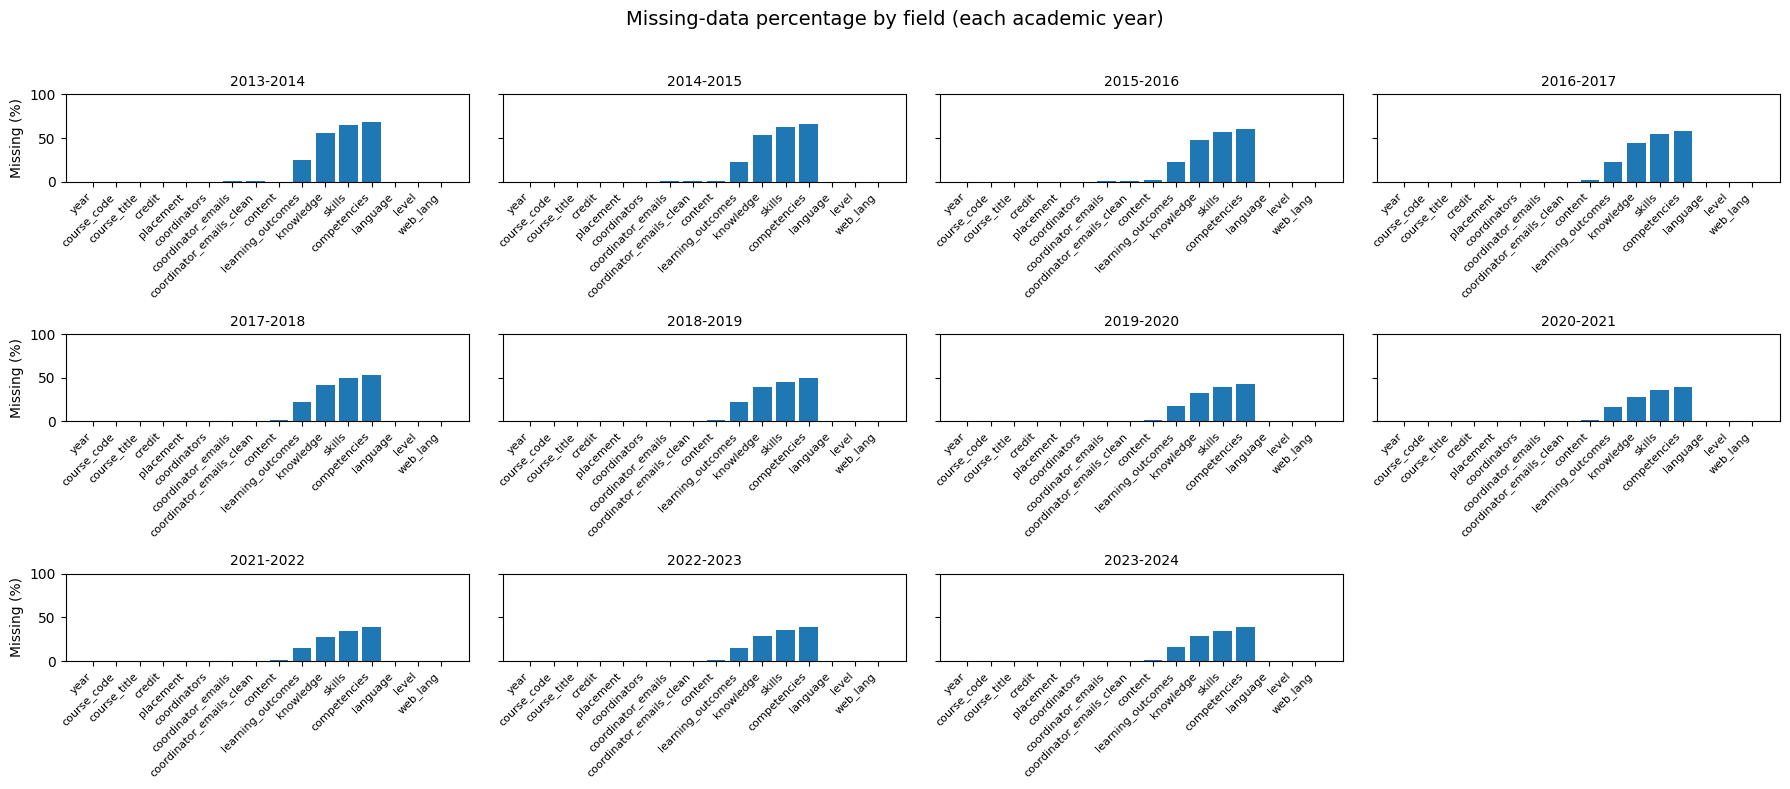

In [28]:
# Plot missing-data percentages by field for each academic year
nrows, ncols = 3, 4

# Produce a grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8), sharey=True)
axes = axes.flatten()

# Plot each year's missing data as a bar chart
for idx, yr in enumerate(years):
    ax = axes[idx]
    yvals = [pct_missing[yr][fld] for fld in FIELDS]
    ax.bar(range(len(FIELDS)), yvals)
    ax.set_title(yr, fontsize=10)
    ax.set_xticks(range(len(FIELDS)))
    ax.set_xticklabels(FIELDS, rotation=45, ha="right", fontsize=8)
    ax.set_ylim(0, 100)
    if idx % ncols == 0:
        ax.set_ylabel("Missing (%)")

# Hide unused axes if <10 years
for ax in axes[len(years):]:
    ax.axis("off")

# Add a super title and adjust layout
fig.suptitle("Missing-data percentage by field (each academic year)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

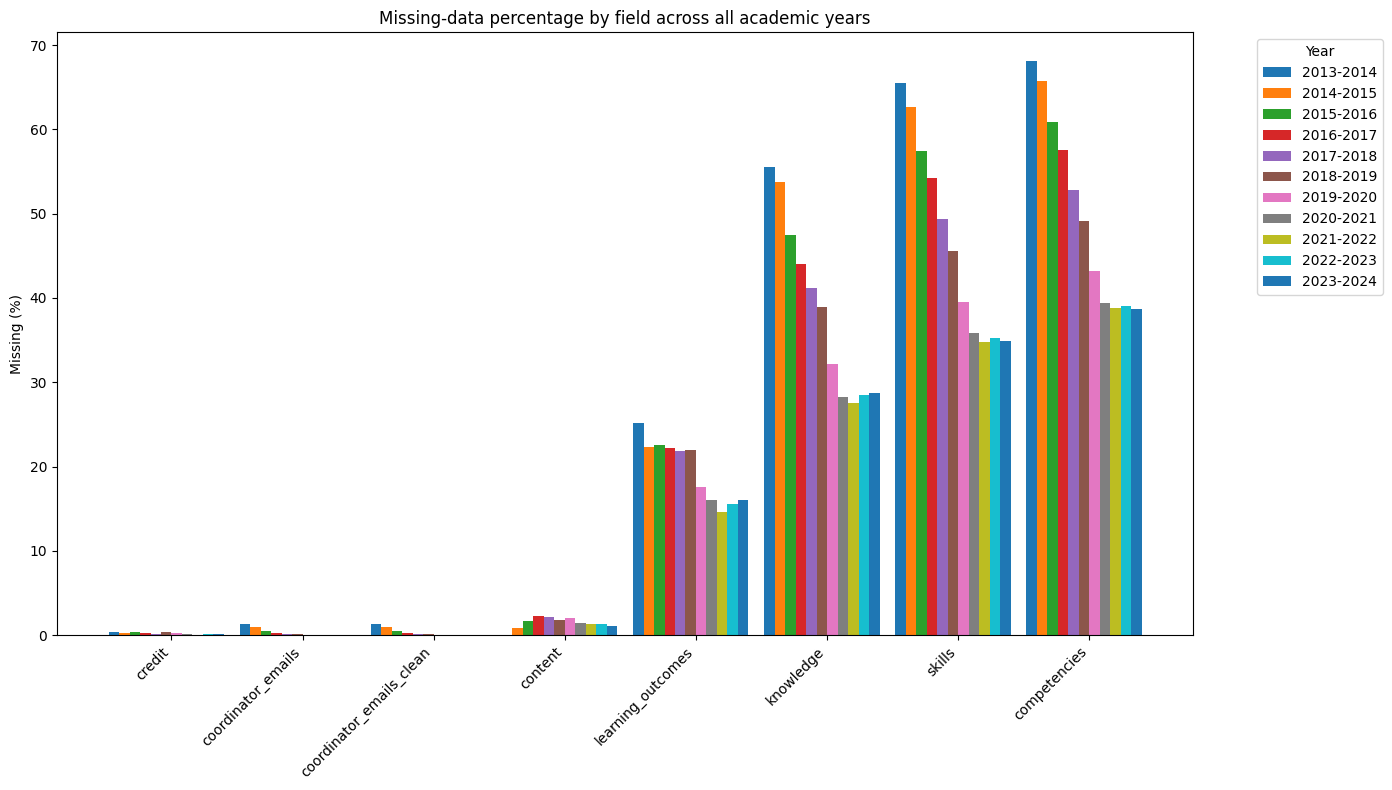

In [29]:
# Create a grouped bar chart for missing data percentages across all years
bar_width = 0.08  # Width of each bar

# Filter fields with missing data > 0 for any year
fields_with_missing = [
    fld for fld in FIELDS if any(pct_missing[yr][fld] > 0 for yr in years)
]
x_indices = np.arange(len(fields_with_missing))  # X positions for filtered fields

plt.figure(figsize=(14, 8))

# Plot bars for each year
for i, yr in enumerate(years):
    yvals = [pct_missing[yr][fld] for fld in fields_with_missing]
    plt.bar(x_indices + i * bar_width, yvals, bar_width, label=yr)

# Add labels and formatting
plt.xticks(x_indices + (len(years) * bar_width) / 2, fields_with_missing, rotation=45, ha="right")
plt.ylabel("Missing (%)")
plt.title("Missing-data percentage by field across all academic years")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Graph 3: Average character length of text fields over time


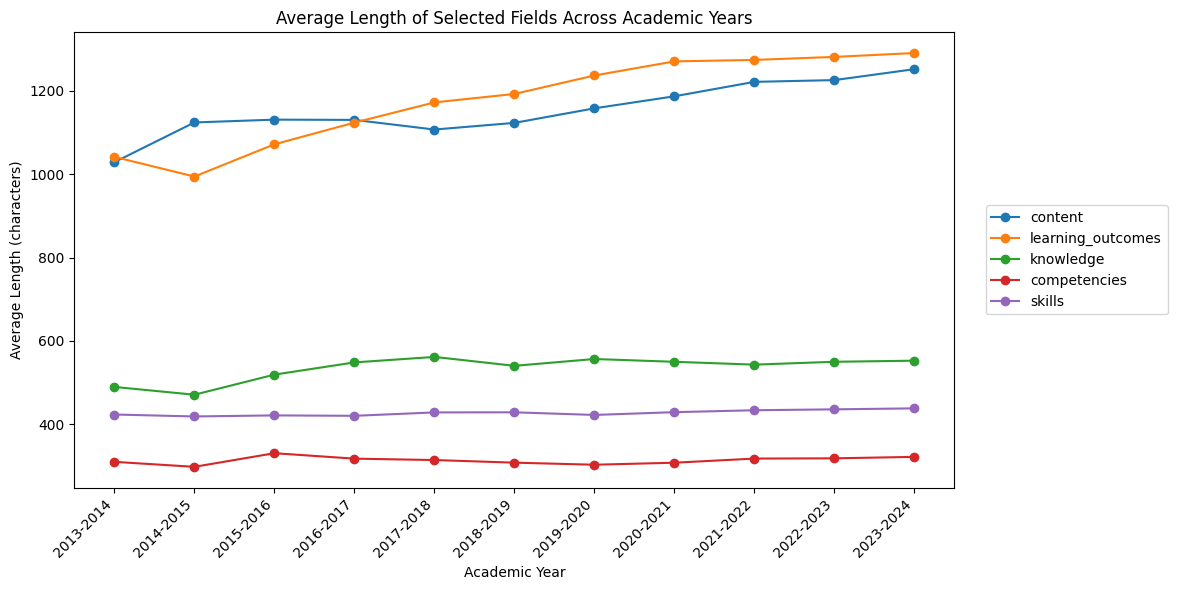

In [30]:
# Plot average lengths of specified fields across years
plt.figure(figsize=(12, 6))
fields_to_plot = ['content', 'learning_outcomes', 'knowledge', 'competencies', 'skills']

# Calculate average length of fields across years (ignoring missing fields)
avg_lengths_by_year = {yr: {fld: [] for fld in FIELDS} for yr in years}
for rec in records:
    yr = rec.get("year")
    if yr in avg_lengths_by_year:
        for fld in FIELDS:
            if fld == "year":  # Skip 'year' field
                continue
            value = rec.get(fld)
            if isinstance(value, str) and value.strip():
                avg_lengths_by_year[yr][fld].append(len(value))
            elif isinstance(value, (list, tuple)) and value:
                avg_lengths_by_year[yr][fld].append(sum(len(str(v)) for v in value) / len(value))
            else:
                continue

# Calculate average length by year
avg_by_year = {
    yr: {fld: np.mean(avg_lengths_by_year[yr][fld]) if avg_lengths_by_year[yr][fld] else 0 for fld in FIELDS if fld != "year"}
    for yr in years
}

for fld in fields_to_plot:
    yvals = [avg_by_year[yr][fld] for yr in years]
    plt.plot(years, yvals, marker='o', label=fld)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Academic Year")
plt.ylabel("Average Length (characters)")
plt.title("Average Length of Selected Fields Across Academic Years")
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))  # Move legend to center-right
plt.tight_layout()
plt.show()